# Utility 

In [1]:
from Funcs.Utility import *
import numpy as np
import pandas as pd
from typing import Dict, Callable, Union, Tuple, List, Optional, Iterable
from datetime import timedelta as td
from scipy import stats
import ray
import warnings
import time

## Labels

In [2]:
import pandas as pd
import os

LABELS = pd.read_csv(PATH_ESM).assign(
    timestamp=lambda x: pd.to_datetime(x['responseTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
).set_index(
    ['pcode', 'timestamp']
)
LABELS.head()

responseTime  scheduledTime  valence  \
pcode timestamp                                                          
P01   2019-05-08 10:15:03+09:00  1557278103000            NaN        0   
      2019-05-08 10:29:46+09:00  1557278986000   1.557279e+12       -3   
      2019-05-08 11:16:12+09:00  1557281772000   1.557282e+12       -3   
      2019-05-08 12:45:38+09:00  1557287138000            NaN        2   
      2019-05-08 13:51:57+09:00  1557291117000            NaN        3   

                                 arousal  attention  stress  duration  \
pcode timestamp                                                         
P01   2019-05-08 10:15:03+09:00        0          0      -1      20.0   
      2019-05-08 10:29:46+09:00        3          3       3       5.0   
      2019-05-08 11:16:12+09:00       -2          2       2      15.0   
      2019-05-08 12:45:38+09:00       -1          2       0      15.0   
      2019-05-08 13:51:57+09:00        3          3      -3      20.0   

                                 disturbance  change  
pcode timestamp                                       
P01   2019-05-08 10:15:03+09:00            3      -2  
      2019-05-08 10:29:46+09:00           -1      -3  
      2019-05-08 11:16:12+09:00            3      -2  
      2019-05-08 12:45:38+09:00            1      -1  
      2019-05-08 13:51:57+09:00            1       0

In [3]:
LABELS_VALID = LABELS.loc[
    lambda x: ~x['scheduledTime'].isna(), :
]
print(f'# Non-voluntary response: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

excl_pcode = LABELS_VALID.loc[
    lambda x: ~x['scheduledTime'].isna()
].groupby('pcode').count().iloc[:, -1].loc[lambda y: y < 35]

LABELS_VALID = LABELS_VALID.loc[
    lambda x:  ~x.index.get_level_values('pcode').isin(excl_pcode.index), :
]
print(f'# Response from participants with enough responses: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

print('# Participants whose responses to ESM delivery were less then 35')
print(excl_pcode, f'#participants = {len(excl_pcode)} / #response = {sum(excl_pcode)}')

# Non-voluntary response: 3323
{'n': 76, 'sum': 3323, 'mean': 43.723684210526315, 'SD': 19.36291898394835, 'med': 43.5, 'range': (3, 83), 'conf.': (39.29906768359284, 48.14830073745979), 'nan_count': 0}
# Response from participants with enough responses: 2619
{'n': 47, 'sum': 2619, 'mean': 55.723404255319146, 'SD': 13.076201628480542, 'med': 52.0, 'range': (36, 83), 'conf.': (51.88408763344431, 59.56272087719398), 'nan_count': 0}
# Participants whose responses to ESM delivery were less then 35
pcode
P04    34
P07    24
P11    22
P14    11
P16    30
P17    13
P18    32
P20    31
P22    23
P24    10
P25    30
P29    32
P34    22
P36    29
P37    31
P38    33
P41    31
P43    24
P44    23
P46     4
P54    13
P56    31
P58    29
P62     3
P63    34
P64    30
P68    11
P73    31
P74    33
Name: change, dtype: int64 #participants = 29 / #response = 704


In [4]:
LABELS_dropped= LABELS.loc[
    lambda x: ~x['scheduledTime'].isna(), :
].loc[excl_pcode.index]

In [5]:
LABELS_dropped

responseTime  scheduledTime  valence  \
pcode timestamp                                                          
P04   2019-05-08 10:09:40+09:00  1557277780000   1.557278e+12       -2   
      2019-05-08 12:10:34+09:00  1557285034000   1.557285e+12       -1   
      2019-05-08 12:54:12+09:00  1557287652000   1.557288e+12        0   
      2019-05-08 15:09:13+09:00  1557295753000   1.557296e+12        0   
      2019-05-08 18:54:26+09:00  1557309266000   1.557309e+12        1   
...                                        ...            ...      ...   
P74   2019-05-05 20:25:50+09:00  1557055550000   1.557056e+12        1   
      2019-05-06 14:29:18+09:00  1557120558000   1.557121e+12       -1   
      2019-05-06 15:11:46+09:00  1557123106000   1.557123e+12        0   
      2019-05-06 18:59:29+09:00  1557136769000   1.557137e+12        0   
      2019-05-06 21:14:44+09:00  1557144884000   1.557145e+12        1   

                                 arousal  attention  stress  duration  \
pcode timestamp                                                         
P04   2019-05-08 10:09:40+09:00       -2          2       1      30.0   
      2019-05-08 12:10:34+09:00       -2          1       1      30.0   
      2019-05-08 12:54:12+09:00        1          2       0      30.0   
      2019-05-08 15:09:13+09:00       -3          0      -1      20.0   
      2019-05-08 18:54:26+09:00        2          2      -1      20.0   
...                                  ...        ...     ...       ...   
P74   2019-05-05 20:25:50+09:00       -1          1       1      30.0   
      2019-05-06 14:29:18+09:00       -1          0       2      30.0   
      2019-05-06 15:11:46+09:00        0          0       1      30.0   
      2019-05-06 18:59:29+09:00       -1          2       1      30.0   
      2019-05-06 21:14:44+09:00       -1          0       1      30.0   

                                 disturbance  change  
pcode timestamp                                       
P04   2019-05-08 10:09:40+09:00            1       2  
      2019-05-08 12:10:34+09:00            3      -1  
      2019-05-08 12:54:12+09:00            3       0  
      2019-05-08 15:09:13+09:00           -1       1  
      2019-05-08 18:54:26+09:00           -3       0  
...                                      ...     ...  
P74   2019-05-05 20:25:50+09:00            2       0  
      2019-05-06 14:29:18+09:00            0       0  
      2019-05-06 15:11:46+09:00            0       0  
      2019-05-06 18:59:29+09:00            3       0  
      2019-05-06 21:14:44+09:00            0       0  

[704 rows x 9 columns]

In [6]:
import pandas as pd
import numpy as np


LABELS_PROC = LABELS_dropped.assign(
    valence_dyn = lambda x: np.where(x['valence'] > LABELS_VALID['valence'].mean(), 1, 0),
    arousal_dyn = lambda x: np.where(x['arousal'] > LABELS_VALID['arousal'].mean(), 1, 0),
    stress_dyn = lambda x: np.where(x['stress'] > LABELS_VALID['stress'].mean(), 1, 0),
    disturbance_dyn = lambda x: np.where(x['disturbance'] > LABELS_VALID['disturbance'].mean(), 1, 0),
    valence_fixed = lambda x: np.where(x['valence'] > 0, 1, 0),
    arousal_fixed = lambda x: np.where(x['arousal'] > 0, 1, 0),
    stress_fixed = lambda x: np.where(x['stress'] > 0, 1, 0),
    disturbance_fixed = lambda x: np.where(x['disturbance'] > 0, 1, 0),        
)
LABELS_PROC.head()

responseTime  scheduledTime  valence  \
pcode timestamp                                                          
P04   2019-05-08 10:09:40+09:00  1557277780000   1.557278e+12       -2   
      2019-05-08 12:10:34+09:00  1557285034000   1.557285e+12       -1   
      2019-05-08 12:54:12+09:00  1557287652000   1.557288e+12        0   
      2019-05-08 15:09:13+09:00  1557295753000   1.557296e+12        0   
      2019-05-08 18:54:26+09:00  1557309266000   1.557309e+12        1   

                                 arousal  attention  stress  duration  \
pcode timestamp                                                         
P04   2019-05-08 10:09:40+09:00       -2          2       1      30.0   
      2019-05-08 12:10:34+09:00       -2          1       1      30.0   
      2019-05-08 12:54:12+09:00        1          2       0      30.0   
      2019-05-08 15:09:13+09:00       -3          0      -1      20.0   
      2019-05-08 18:54:26+09:00        2          2      -1      20.0   

                                 disturbance  change  valence_dyn  \
pcode timestamp                                                     
P04   2019-05-08 10:09:40+09:00            1       2            0   
      2019-05-08 12:10:34+09:00            3      -1            0   
      2019-05-08 12:54:12+09:00            3       0            0   
      2019-05-08 15:09:13+09:00           -1       1            0   
      2019-05-08 18:54:26+09:00           -3       0            1   

                                 arousal_dyn  stress_dyn  disturbance_dyn  \
pcode timestamp                                                             
P04   2019-05-08 10:09:40+09:00            0           1                1   
      2019-05-08 12:10:34+09:00            0           1                1   
      2019-05-08 12:54:12+09:00            1           1                1   
      2019-05-08 15:09:13+09:00            0           0                0   
      2019-05-08 18:54:26+09:00            1           0                0   

                                 valence_fixed  arousal_fixed  stress_fixed  \
pcode timestamp                                                               
P04   2019-05-08 10:09:40+09:00              0              0             1   
      2019-05-08 12:10:34+09:00              0              0             1   
      2019-05-08 12:54:12+09:00              0              1             0   
      2019-05-08 15:09:13+09:00              0              0             0   
      2019-05-08 18:54:26+09:00              1              1             0   

                                 disturbance_fixed  
pcode timestamp                                     
P04   2019-05-08 10:09:40+09:00                  1  
      2019-05-08 12:10:34+09:00                  1  
      2019-05-08 12:54:12+09:00                  1  
      2019-05-08 15:09:13+09:00                  0  
      2019-05-08 18:54:26+09:00                  0

In [7]:
LABELS_PROC.to_csv(os.path.join(PATH_INTERMEDIATE, 'proc', 'LABELS_CFF_Rule_Generate.csv'), index=True)

## Epoch Feature Extraction

In [8]:
def _safe_na_check(_v):
    _is_nan_inf = False
    
    try:
        _is_nan_inf = np.isnan(_v) or np.isinf(_v)
    except:
        _is_nan_inf = False
    
    return _is_nan_inf or _v is None

In [9]:
import neurokit2 as nk
from scipy.signal import find_peaks
from scipy.integrate import simps

def _extract_eda( d_val) :
    # Set the sampling rate of your data (in Hz, e.g., 1000 samples per second)
    sampling_rate = 2

    _feature = {}
    v =d_val
    
    if len(v) == 0:
        return {}

    # Raw EDA
    mean_eda = np.mean(v)
    max_eda = np.max(v)
    min_eda = np.min(v)
    std_eda = np.std(v)
    peaks, _ = find_peaks(v)
    num_peaks_eda = len(peaks)
    auc_eda = simps(v, dx=1 / sampling_rate)
    
    if len(v) <10:
        print(f"Warning: EDA signal is too short: {len(v)} elements")
        # Combine features into a dictionary
        all_features = {
            'mean_eda': mean_eda,
            'max_eda': max_eda,
            'min_eda': min_eda,
            'std_eda': std_eda,
            'num_peaks_eda': num_peaks_eda,
            'auc_eda': auc_eda
        }

    else:
        # Decomposing EDA
        data = nk.eda_phasic(v, sampling_rate=2)

        # Tonic EDA
        mean_tonic = np.mean(data['EDA_Tonic'])
        max_tonic = np.max(data['EDA_Tonic'])
        min_tonic = np.min(data['EDA_Tonic'])
        std_tonic = np.std(data['EDA_Tonic'])
        peaks, _ = find_peaks(data['EDA_Tonic'])
        num_peaks_tonic = len(peaks)
        auc_tonic = simps(data['EDA_Tonic'], dx=1 / sampling_rate)

        # Phasic EDA
        mean_phasic = np.mean(data['EDA_Phasic'])
        max_phasic = np.max(data['EDA_Phasic'])
        min_phasic = np.min(data['EDA_Phasic'])
        std_phasic = np.std(data['EDA_Phasic'])
        peaks, _ = find_peaks(data['EDA_Phasic'])
        num_peaks_phasic = len(peaks)
        auc_phasic = simps(data['EDA_Phasic'], dx=1 / sampling_rate)


        # Combine features into a dictionary
        all_features = {
            'mean_eda': mean_eda,
            'max_eda': max_eda,
            'min_eda': min_eda,
            'std_eda': std_eda,
            'num_peaks_eda': num_peaks_eda,
            'auc_eda': auc_eda,
            'mean_tonic': mean_tonic,
            'max_tonic': max_tonic,
            'min_tonic': min_tonic,
            'std_tonic': std_tonic,
            'num_peaks_tonic': num_peaks_tonic,
            'auc_tonic': auc_tonic,
            'auc_phasic': auc_phasic,
            'mean_phasic': mean_phasic,
            'max_phasic': max_phasic,
            'min_phasic': min_phasic,
            'std_phasic': std_phasic,
            'num_peaks_phasic': num_peaks_phasic,
            'auc_phasic': auc_phasic
        }



    for feature, value in all_features.items():
        _feature[f'EDA#{feature}']= value
    
    return _feature

In [10]:
from scipy import stats

def _extract_rri( d_val) :
    _feature = {}
    v =d_val
    
    if len(v) == 0:
        return {}
    
    # Extract features
    mean = np.mean(v)
    median = np.median(v)
    maximum = np.max(v)
    minimum = np.min(v)
    std_dev = np.sqrt(np.var(v, ddof=1)) if len(v) > 1 else 0
    kurt = stats.kurtosis(v, bias=False)
    skw = stats.skew(v, bias=False)
    # Calculate the slope of column
    slope, _ = np.polyfit(np.arange(len(v)), v, 1)
    percentile_80 = v.quantile(0.8)
    percentile_20 = v.quantile(0.2)
    
    # RMSSD
    rmssd = np.sqrt(np.mean(np.diff(v)**2))

    # Combine features into a dictionary
    all_features = {
        "mean": mean,
        "median": median,
        "maximum": maximum,
        "minimum": minimum,
        "std_dev": std_dev,
        "kurt": kurt,
        "skw": skw,
        "slope": slope,
        "percentile_80": percentile_80,
        "percentile_20": percentile_20,
        "rmssd": rmssd
    }



    for feature, value in all_features.items():
        _feature[f'HRV#{feature}']= value
    
    return _feature


In [11]:
def _extract_numeric_feature(d_key, d_val) -> Dict:
    feature = {}
    v=d_val
    hist, _ = np.histogram(v, bins='doane', density=False)
    std = np.sqrt(np.var(v, ddof=1)) if len(v) > 1 else 0
    v_norm = (v - np.mean(v)) / std if std != 0 else np.zeros(len(v))
    feature[f'{d_key}#AVG'] = np.mean(v) # Sample mean
    feature[f'{d_key}#STD'] = std # Sample standard deviation
    if std !=0:
        feature[f'{d_key}#SKW'] = stats.skew(v, bias=False) # Sample skewness
        feature[f'{d_key}#KUR'] = stats.kurtosis(v, bias=False) # Sample kurtosis
    else:
        feature[f'{d_key}#SKW'] = -3 # Sample skewness
        feature[f'{d_key}#KUR'] = -3 # Sample kurtosis
    feature[f'{d_key}#ASC'] = np.sum(np.abs(np.diff(v))) # Abstract sum of changes
    feature[f'{d_key}#BEP'] = stats.entropy(hist) # Binned entropy
    feature[f'{d_key}#MED'] = np.median(v) # Median
    feature[f'{d_key}#TSC'] = np.sqrt(np.sum(np.power(np.diff(v_norm), 2))) # Timeseries complexity
    return feature

In [12]:
def _extract_categorical_feature(cats, d_key, d_val) -> Dict:
    feature = {}
    v = d_val
    cnt = v.value_counts()
    val, sup = cnt.index, cnt.values
    hist = {k: v for k, v in zip(val, sup)}

    # Information Entropy
    feature[f'{d_key}#ETP#'] = stats.entropy(sup / len(v))
    # Abs. Sum of Changes
    feature[f'{d_key}#ASC#'] = np.sum(v.values[1:] != v.values[:-1])
    if len(cats) == 2: # Dichotomous categorical data
        c = cats[0]
        feature[f'{d_key}#RLV_SUP'] = hist[c] / len(v) if c in hist else 0
    else:
        for c in cats:
            feature[f'{d_key}#RLV_SUP={c}'] = hist[c] / len(v)  if c in hist else 0
            
    return feature

In [13]:
def _extract_timeWindow_feature(is_numeric, cats, d_key, d_val) -> Dict:
    feature = {}
    v = d_val
    if d_key in ['CAE_DUR']:
        feature = _extract_numeric_feature(d_key, v)
        feature['CAE#FREQ'] = len(v)
    elif d_key in ['LOC_CLS']:
        feature = _extract_categorical_feature(cats, d_key, v)
        feature['LOC#NumOfPlcVist'] = len(set(v))
    elif d_key in ['EDA']:
        feature = _extract_eda(v)
    elif d_key in ['RRI']:
        feature = _extract_rri(v)
    else:
        if is_numeric:
            feature = _extract_numeric_feature(d_key, v)
        else:
            feature =_extract_categorical_feature(cats, d_key, v)
    return feature

In [14]:
epoch_names = {
    0: 'Dawn',
    1: 'Morning',
    2: 'Afternoon',
    3: 'LateAfternoon',
    4: 'Evening',
    5: 'Night'
}
def _extract_epoch(
        pid: str,
        data: Dict[str, pd.Series],
        label: pd.Series,
        label_values: List[str],
#        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
#        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
        categories: Dict[str, Optional[List[any]]] = None,
        resample_s: Dict[str, float] = None
) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    _s = time.time()
    log(f"Begin feature extraction on {pid}'s data.")
    categories = categories or dict()
    resample_s = resample_s or dict()
    X, y, date_times = [], [], []
#    count = 0
    for timestamp in label.index:
        row = dict()
        #Find the start of today and yesterday for extracting today epoch features and yesterday epoch features
        start_of_today = datetime(timestamp.year, timestamp.month, timestamp.day, tzinfo=timestamp.tzinfo)
        start_of_today = pd.Timestamp(start_of_today.date(), tz=DEFAULT_TZ)
        start_of_yesterday = timestamp - pd.Timedelta(days=1)
        start_of_yesterday = pd.Timestamp(start_of_yesterday.date(), tz=DEFAULT_TZ)
        label_cur = label.at[timestamp]
        yesterday_time_windows = [
                (start_of_yesterday + pd.Timedelta(hours=6), start_of_yesterday + pd.Timedelta(hours=9)),
                (start_of_yesterday + pd.Timedelta(hours=9), start_of_yesterday + pd.Timedelta(hours=12)),
                (start_of_yesterday + pd.Timedelta(hours=12), start_of_yesterday + pd.Timedelta(hours=15)),
                (start_of_yesterday + pd.Timedelta(hours=15), start_of_yesterday + pd.Timedelta(hours=18)),
                (start_of_yesterday + pd.Timedelta(hours=18), start_of_yesterday + pd.Timedelta(hours=21)),
                (start_of_yesterday + pd.Timedelta(hours=21), start_of_yesterday + pd.Timedelta(hours=24))
            ]
        today_time_windows = []
        for i in range(6):
            start = start_of_today + pd.Timedelta(hours=i*3+6) #We add 6 because we ignore the midnight time
            end = start_of_today + pd.Timedelta(hours=(i+1)*3)
            if start <= timestamp:
                today_time_windows.append((start, min(end, timestamp)))
            else:
                break
                
        print(today_time_windows)
        t = timestamp - td(milliseconds=1)

        # Features from sensor data
        for d_key, d_val in data.items():
            is_numeric = d_key not in categories
            cats = categories.get(d_key) or list()
            d_val = d_val.sort_index()

            # Features extracted from time-windows
            # These features requires resampling and imputation on each data.
            sample_rate = RESAMPLE_S.get(d_key) or 1
            d_val_res = d_val.resample(f'{sample_rate}S', origin='start')
            if is_numeric:
                try:
                    # Your resampling code here...
                    d_val_res = d_val_res.mean().interpolate(method='time').dropna()
                except ValueError:
                    # Save input data to a file or external storage for debugging...
                    print(d_val_res)
                    print(d_val)
                    raise
            else:
                d_val_res = d_val_res.ffill().dropna()
                    
            #Features extracted from today epoch time windows until current time
            for count, (start, end) in enumerate(today_time_windows):
                # Get data for the current time window
                try:
                    v = d_val_res.loc[start:end]
                except (KeyError, IndexError):
                    continue
                epoch_name = epoch_names.get(count)
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    new_row = {f'{k}#Today{epoch_name}': v for k, v in _extract_timeWindow_feature(is_numeric, cats, d_key, v).items()}
                    row.update(new_row)

        row = {
            k: 0 if _safe_na_check(v) else v
#             k:  v
            for k, v in row.items()
        }

        X.append(row)
        y.append(label_cur)
        date_times.append(timestamp)
    
    log(f"Complete feature extraction on {pid}'s data ({time.time() - _s:.2f} s).")
    X = pd.DataFrame(X)
    y = np.asarray(y)
    group = np.repeat(pid, len(y))
    date_times =  np.asarray(date_times)
    return X, y, group, date_times
def extract_epoch(
        pids: Iterable[str],
        data: Dict[str, pd.Series],
        label: pd.Series,
        label_values: List[str],
#        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
#        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
        categories: Dict[str, Optional[List[any]]] = None,
        resample_s: Dict[str, float] = None,
        with_ray: bool=False
):
    if with_ray and not ray.is_initialized():
        raise EnvironmentError('Ray should be initialized if "with_ray" is set as True.')
    func = ray.remote(_extract_epoch).remote if with_ray else _extract_epoch
    jobs = []
    for pid in pids:
        d = dict()
        for k, v in data.items():
            try:
                d[k] = v.loc[(pid, )]
                if k.startswith('LOC_'):
                    d[k].index= pd.to_datetime( d[k].index, unit='ms', utc=True).tz_convert(DEFAULT_TZ)
                d['SPEED'] = d.pop('LOC_SPEED')
            except (KeyError, IndexError):
                pass
        job = func(
            pid=pid, data=d, label=label.loc[(pid, )],
            label_values=label_values,
#            window_data=window_data,
#            window_label=window_label,
            categories=categories,
            resample_s=resample_s
        )
        jobs.append(job)
    jobs = ray.get(jobs) if with_ray else jobs
    print([x.shape for _, x, _, _ in jobs])
    X = pd.concat([x for x, _, _, _ in jobs], axis=0, ignore_index=True)
    y = np.concatenate([x for _, x, _, _ in jobs], axis=0)
    group = np.concatenate([x for _, _, x, _ in jobs], axis=0)
    date_times = np.concatenate([x for _, _, _, x in jobs], axis=0)
    t_s = date_times.min().normalize().timestamp()
    t_norm = np.asarray(list(map(lambda x: x.timestamp() - t_s, date_times)))
    C, DTYPE = X.columns, X.dtypes
#     X = X.fillna({
#         **{c: False for c in C[(DTYPE == object) | (DTYPE == bool)]},
#         **{c: 0.0 for c in C[(DTYPE != object) & (DTYPE != bool)]},
#     }).astype({
#         **{c: 'bool' for c in C[(DTYPE == object) | (DTYPE == bool)]},
#         **{c: 'float32' for c in C[(DTYPE != object) & (DTYPE != bool)]},
#     })
    return X, y, group, t_norm, date_times

In [15]:
import os
import cloudpickle

LABEL_VALUES = [1, 0]
RESAMPLE_S = {
    'ACC_AXX': 0.25,
    'ACC_AXY': 0.25,
    'ACC_AXZ': 0.25,
    'ACC_MAG': 0.25,
    'EDA': 0.5,
}

CATEGORIES = {
   'DST_MOT': ['IDLE', 'WALKING', 'JOGGING', 'RUNNING'],
   'ULV_INT': ['NONE', 'LOW', 'MEDIUM', 'HIGH'],
    'ACT': ['WALKING', 'STILL', 'IN_VEHICLE', 'ON_BICYCLE', 'RUNNING'],
#    'APP_PAC': None,
    'APP_CAT': ['SOCIAL','HEALTH','ENTER','WORK',"INFO"],
   'BAT_STA': ['CHARGING', 'DISCHARGING', 'FULL', 'NOT_CHARGING'],
#    'CAE': ['CALL', 'IDLE'],
   'CON': ['DISCONNECTED', 'WIFI', 'MOBILE'],
    'LOC_CLS': None,
    'LOC_LABEL': ['eating','home','work','social','others'] ,
    'SCR_EVENT':['ON', 'OFF', 'UNLOCK'],
    'RNG': ['VIBRATE', 'SILENT', 'NORMAL'],
    'CHG': ['DISCONNECTED', 'CONNECTED'],
    'PWS': ['ACTIVATE', 'DEACTIVATE'],
    'ONF': ['ON', 'OFF']
}
DATA = load(os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))
LABELS_PROC = pd.read_csv(os.path.join(PATH_INTERMEDIATE, 'proc', 'LABELS_CFF_Rule_Generate.csv'), index_col=['pcode','timestamp'],parse_dates=True)

In [16]:
import warnings
from pandas.errors import PerformanceWarning

warnings.simplefilter(action='ignore', category=PerformanceWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)


#with on_ray(num_cpus=12):
with on_ray():
    #for l in ['valence', 'arousal', 'stress', 'disturbance']:
    for l in ['stress']:
        #In preprocessing, dynamic threshold shows better data balance
        labels = LABELS_PROC[f'{l}_dyn']
        pids = labels.index.get_level_values('pcode').unique()
        feat = extract_epoch(
            pids=pids,
            data=DATA,
            label=labels,
            label_values=LABEL_VALUES,
#            window_data=WINDOW_DATA,
#            window_label=WINDOW_LABEL,
            categories=CATEGORIES,
            resample_s=RESAMPLE_S,
            with_ray=True
        )
        dump(feat, os.path.join(PATH_INTERMEDIATE, 'feat', f'{l}_CFF.pkl'))

2023-06-07 19:05:52,049	INFO worker.py:1432 -- Connecting to existing Ray cluster at address: 192.168.1.28:6379...
2023-06-07 19:05:52,103	INFO worker.py:1616 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


(_extract_epoch pid=176632) [23-06-07 19:05:56] Begin feature extraction on P04's data.
(_extract_epoch pid=176632) [(Timestamp('2019-05-08 00:00:00+0900', tz='pytz.FixedOffset(540)'), Timestamp('2019-05-08 03:00:00+0900', tz='pytz.FixedOffset(540)')), (Timestamp('2019-05-08 03:00:00+0900', tz='pytz.FixedOffset(540)'), Timestamp('2019-05-08 06:00:00+0900', tz='pytz.FixedOffset(540)')), (Timestamp('2019-05-08 06:00:00+0900', tz='pytz.FixedOffset(540)'), Timestamp('2019-05-08 09:00:00+0900', tz='pytz.FixedOffset(540)')), (Timestamp('2019-05-08 09:00:00+0900', tz='pytz.FixedOffset(540)'), Timestamp('2019-05-08 10:09:40+0900', tz='pytz.FixedOffset(540)'))]
(_extract_epoch pid=176827) [23-06-07 19:06:01] Begin feature extraction on P11's data. [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(_extract_epoch pid=176631)

KeyboardInterrupt: 

## Aggregated Feature Extraction

In [18]:
l='stress'
p=os.path.join(PATH_INTERMEDIATE, 'feat', f'{l}_CFF.pkl')
X, y, groups, t, datetimes = load(p)
df =X
labels_arm = pd.read_csv(os.path.join(PATH_INTERMEDIATE, 'proc', 'LABELS_CFF_Rule_Generate.csv'), index_col=['pcode','timestamp'],parse_dates=True)

In [65]:
df

,ACC_AXX#AVG#TodayDawn,ACC_AXX#STD#TodayDawn,ACC_AXX#SKW#TodayDawn,ACC_AXX#KUR#TodayDawn,ACC_AXX#ASC#TodayDawn,ACC_AXX#BEP#TodayDawn,ACC_AXX#MED#TodayDawn,ACC_AXX#TSC#TodayDawn,ACC_AXX#AVG#TodayMorning,ACC_AXX#STD#TodayMorning,...,MED_VID#MED#TodayEvening,MED_VID#TSC#TodayEvening,MED_VID#AVG#TodayNight,MED_VID#STD#TodayNight,MED_VID#SKW#TodayNight,MED_VID#KUR#TodayNight,MED_VID#ASC#TodayNight,MED_VID#BEP#TodayNight,MED_VID#MED#TodayNight,MED_VID#TSC#TodayNight
0,0.000000,0.000000,-3.000000e+00,-3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.000000,-3.000000e+00,-3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.000000,-3.000000e+00,-3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000,0.000000,-3.000000e+00,-3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.000000,-3.000000e+00,-3.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,0.614213,0.032042,3.145712e-07,-1.2,0.110994,2.833213,0.614213,0.016667,0.503217,0.032042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700,-0.273757,0.032042,6.291423e-08,-1.2,0.110994,2.833213,-0.273757,0.016666,-0.384754,0.032042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
701,-0.273757,0.032042,6.291423e-08,-1.2,0.110994,2.833213,-0.273757,0.016666,-0.384754,0.032042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
702,-0.273757,0.032042,6.291423e-08,-1.2,0.110994,2.833213,-0.273757,0.016666,-0.384754,0.032042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# datetimes[0].hour

In [69]:
datetimes[0].hour

10

In [66]:
selected_cols = [x for x in X.keys() if 'ACC_AXX#STD' in x]
selected_df = X[selected_cols]

In [67]:
selected_df

,ACC_AXX#STD#TodayDawn,ACC_AXX#STD#TodayMorning,ACC_AXX#STD#TodayAfternoon,ACC_AXX#STD#TodayLateAfternoon,ACC_AXX#STD#TodayEvening,ACC_AXX#STD#TodayNight
0,0.000000,0.000000,0.000000,0.000000,NaN,NaN
1,0.000000,0.000000,0.000000,0.552280,0.200996,NaN
2,0.000000,0.000000,0.000000,0.552280,0.337420,NaN
3,0.000000,0.000000,0.000000,0.552280,0.397859,0.110843
4,0.000000,0.000000,0.000000,0.552280,0.397859,0.467074
...,...,...,...,...,...,...
699,0.032042,0.032042,0.032042,0.032042,0.032042,0.032042
700,0.032042,0.032042,0.032042,0.032042,0.419294,NaN
701,0.032042,0.032042,0.032042,0.032042,0.614923,0.034948
702,0.032042,0.032042,0.032042,0.032042,0.614923,0.395583


In [31]:
# Define a function to split the column name into sensor and attribute
def split_column_name(col_name):
    parts = col_name.rsplit("#", 1)  # Split on last occurrence of '#'
    return parts[0]  # This gives you 'Sensor#Attribute'

# Get a list of unique sensor-attribute combinations
sensor_attributes = df.columns.map(split_column_name).unique()

# Create a list to hold the aggregated results
agg_results = []

# Loop over each sensor-attribute, select the appropriate columns, compute the mean and std
for sensor_attribute in sensor_attributes:
    # Select columns for this sensor-attribute
    cols_to_aggregate = [col for col in df.columns if col.startswith(sensor_attribute)]
    # Compute the mean and std and store in the new DataFrame
    agg_results.append(df[cols_to_aggregate].mean(axis=1).rename(sensor_attribute + '|'+ 'MEAN'))
    agg_results.append(df[cols_to_aggregate].std(axis=1).rename(sensor_attribute + '|'+'STD'))

# Concatenate all the results into a single DataFrame
agg_feature = pd.concat(agg_results, axis=1)

print(agg_feature)

     ACC_AXX#AVG|MEAN  ACC_AXX#AVG|STD  ACC_AXX#STD|MEAN  ACC_AXX#STD|STD  \
0            0.000000         0.000000          0.000000         0.000000   
1           -0.045207         0.177682          0.150655         0.240794   
2           -0.056817         0.202606          0.177940         0.255221   
3           -0.045606         0.143891          0.176830         0.239991   
4           -0.057052         0.150878          0.236202         0.263330   
..                ...              ...               ...              ...   
699          0.336722         0.207655          0.032042         0.000000   
700         -0.458352         0.130531          0.109493         0.173184   
701         -0.257585         0.403938          0.129673         0.237726   
702         -0.355824         0.189123          0.189779         0.254018   
703         -0.355824         0.189123          0.189779         0.254018   

     ACC_AXX#SKW|MEAN  ACC_AXX#SKW|STD  ACC_AXX#KUR|MEAN  ACC_AXX#KUR|STD  

In [38]:
agg_feature

,ACC_AXX#AVG|MEAN,ACC_AXX#AVG|STD,ACC_AXX#STD|MEAN,ACC_AXX#STD|STD,ACC_AXX#SKW|MEAN,ACC_AXX#SKW|STD,ACC_AXX#KUR|MEAN,ACC_AXX#KUR|STD,ACC_AXX#ASC|MEAN,ACC_AXX#ASC|STD,...,MED_VID#KUR|MEAN,MED_VID#KUR|STD,MED_VID#ASC|MEAN,MED_VID#ASC|STD,MED_VID#BEP|MEAN,MED_VID#BEP|STD,MED_VID#MED|MEAN,MED_VID#MED|STD,MED_VID#TSC|MEAN,MED_VID#TSC|STD
0,0.000000,0.000000,0.000000,0.000000,-3.000000e+00,0.000000,-3.000000,0.000000e+00,0.000000,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.045207,0.177682,0.150655,0.240794,-1.699214e+00,1.781299,-0.366411,4.164704e+00,439.038517,9.514937e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.056817,0.202606,0.177940,0.255221,-1.820140e+00,1.632568,-1.776600,1.724553e+00,480.976880,9.347872e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.045606,0.143891,0.176830,0.239991,-2.254437e+00,2.118243,3.510288,1.212980e+01,486.888522,8.652701e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.057052,0.150878,0.236202,0.263330,-1.357079e+00,1.799771,-1.083846,2.132106e+00,827.088786,1.029274e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,0.336722,0.207655,0.032042,0.000000,-5.242852e-07,0.000003,-1.200000,6.529362e-08,0.110994,3.041687e-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
700,-0.458352,0.130531,0.109493,0.173184,4.712084e-01,1.053653,-0.056522,2.556896e+00,28.134553,6.266258e+01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
701,-0.257585,0.403938,0.129673,0.237726,1.774726e-01,0.434717,-1.109297,2.221769e-01,23.518260,5.733096e+01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
702,-0.355824,0.189123,0.189779,0.254018,1.809876e-01,0.433077,-1.026603,2.690556e-01,130.089504,2.558263e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Feature Selection

The missing value only exists if no sensor data is available for today epochs

In [44]:
agg_feature.isnull().sum(axis=0).sort_values(ascending=False).head(12)

PWS#ETP#|STD        569
PWS#RLV_SUP|STD     569
PWS#RLV_SUP|MEAN    569
PWS#ASC#|STD        569
PWS#ASC#|MEAN       569
PWS#ETP#|MEAN       569
MED_VID#SKW|MEAN    469
MED_VID#AVG|MEAN    469
MED_VID#AVG|STD     469
MED_VID#STD|MEAN    469
MED_VID#STD|STD     469
MED_VID#TSC|STD     469
dtype: int64

In [45]:
feature_selection_meta = pd.DataFrame(columns=['Removal step', 'Remaining number of features'])
feature_selection_meta = feature_selection_meta.append({
    'Removal step':'Original AFs', 'Remaining number of features':928 
},ignore_index=True)
feature_selection_meta

/tmp/ipykernel_173374/408150782.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_selection_meta = feature_selection_meta.append({


,Removal step,Remaining number of features
0,Original AFs,928


### Remove Zero Varaince Feature

In [46]:
agg_feature.var().sort_values(ascending=False).head(12)

AML#ASC|STD         2.298594e+12
AML#ASC|MEAN        8.975853e+11
DAT_RCV#ASC|STD     1.819327e+10
DAT_RCV#ASC|MEAN    1.299165e+10
CAE_DUR#MED|MEAN    7.975248e+09
CAE_DUR#AVG|MEAN    7.903111e+09
DST_PAC#ASC|STD     4.570359e+09
CAE_DUR#MED|STD     3.789514e+09
CAE_DUR#AVG|STD     3.698726e+09
ULV_EXP#ASC|STD     3.048394e+09
DAT_SNT#ASC|STD     2.640582e+09
DST_PAC#ASC|MEAN    2.333152e+09
dtype: float64

In [47]:
def exclude_low_variance(agg_feature, threshold=.0000001):
    agg_feature_non_zero_var = agg_feature.loc[:,agg_feature.var()>threshold]
    num_removed = agg_feature.shape[1]-agg_feature_non_zero_var.shape[1]
    print(f'{num_removed}/{agg_feature.shape[1]} features with variance < {threshold} removed')
    return agg_feature_non_zero_var
agg_feature_non_zero_var = exclude_low_variance(agg_feature)

79/928 features with variance < 1e-07 removed


In [48]:
feature_selection_meta = feature_selection_meta.append({
    'Removal step':'Elimination of zero variance features', 'Remaining number of features':849
},ignore_index=True)
feature_selection_meta

/tmp/ipykernel_173374/1307333117.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_selection_meta = feature_selection_meta.append({


,Removal step,Remaining number of features
0,Original AFs,928
1,Elimination of zero variance features,849


### missing count thresholding

discard if the feature is missing more than 20% of the time


In [49]:
def exclude_missing(agg_feature_non_zero_var, threshold=.2):
    missing_ratio = agg_feature_non_zero_var.isnull().sum(axis=0)/len(agg_feature_non_zero_var)

    agg_feature_percent_missing  = agg_feature_non_zero_var.loc[
        :,(missing_ratio[missing_ratio<threshold]).index
    ]
    num_removed = agg_feature_non_zero_var.shape[1]-agg_feature_percent_missing.shape[1]
    print(f"{num_removed}/{agg_feature_non_zero_var.shape[1]} mostly missing features are removed")
    return agg_feature_percent_missing

    # visuzlize missing ratio
    # fig_size = figsize=(10,5)
    # f, ax = plt.subplots(figsize=fig_size)


    # N, D = agg_feature_non_zero_var.shape
    # missing_ratio.sort_values(ascending=False).plot(linewidth=3)
    # I = np.arange(0,D,50)
    # ax.set_xticks(I,  I)
    # ax.grid()
    # ax.set_xlabel('Sorted Feature Index')
    # ax.set_ylabel('Percentage of missing cases')
      

agg_feature_percent_missing = exclude_missing(
    agg_feature_non_zero_var, threshold=.2)
agg_feature_percent_missing


20/849 mostly missing features are removed


,ACC_AXX#AVG|MEAN,ACC_AXX#AVG|STD,ACC_AXX#STD|MEAN,ACC_AXX#STD|STD,ACC_AXX#SKW|MEAN,ACC_AXX#SKW|STD,ACC_AXX#KUR|MEAN,ACC_AXX#KUR|STD,ACC_AXX#ASC|MEAN,ACC_AXX#ASC|STD,...,MED_ALL#MED|MEAN,MED_ALL#MED|STD,MSG_RCV#AVG|MEAN,MSG_RCV#AVG|STD,MSG_RCV#MED|MEAN,MSG_RCV#MED|STD,MSG_ALL#AVG|MEAN,MSG_ALL#AVG|STD,MSG_ALL#MED|MEAN,MSG_ALL#MED|STD
0,0.000000,0.000000,0.000000,0.000000,-3.000000e+00,0.000000,-3.000000,0.000000e+00,0.000000,0.000000e+00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.045207,0.177682,0.150655,0.240794,-1.699214e+00,1.781299,-0.366411,4.164704e+00,439.038517,9.514937e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-0.056817,0.202606,0.177940,0.255221,-1.820140e+00,1.632568,-1.776600,1.724553e+00,480.976880,9.347872e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.045606,0.143891,0.176830,0.239991,-2.254437e+00,2.118243,3.510288,1.212980e+01,486.888522,8.652701e+02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.057052,0.150878,0.236202,0.263330,-1.357079e+00,1.799771,-1.083846,2.132106e+00,827.088786,1.029274e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,0.336722,0.207655,0.032042,0.000000,-5.242852e-07,0.000003,-1.200000,6.529362e-08,0.110994,3.041687e-09,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
700,-0.458352,0.130531,0.109493,0.173184,4.712084e-01,1.053653,-0.056522,2.556896e+00,28.134553,6.266258e+01,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
701,-0.257585,0.403938,0.129673,0.237726,1.774726e-01,0.434717,-1.109297,2.221769e-01,23.518260,5.733096e+01,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
702,-0.355824,0.189123,0.189779,0.254018,1.809876e-01,0.433077,-1.026603,2.690556e-01,130.089504,2.558263e+02,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [50]:
feature_selection_meta = feature_selection_meta.append({
    'Removal step':'Elimination of mostly missing features', 'Remaining number of features':829
},ignore_index=True)
feature_selection_meta

/tmp/ipykernel_173374/4286195523.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_selection_meta = feature_selection_meta.append({


,Removal step,Remaining number of features
0,Original AFs,928
1,Elimination of zero variance features,849
2,Elimination of mostly missing features,829


### Pairwise Correlation

In [51]:
corr_with_outcome = pd.merge(
    labels_arm.reset_index()['stress_dyn'],
    agg_feature_percent_missing
    ,left_index=True, right_index=True
).corr()['stress_dyn'].abs().sort_values(ascending=False)

corr_with_outcome

stress_dyn                  1.000000
DST_SPD#TSC|STD             0.148811
RNG#RLV_SUP=NORMAL|STD      0.147113
CAE_CNT#TSC|MEAN            0.144377
DAT_SNT#STD|STD             0.127457
                              ...   
DAT_RCV#SKW|MEAN            0.000637
SKT#STD|STD                 0.000417
BAT_TMP#STD|STD             0.000288
DST_MOT#RLV_SUP=IDLE|STD    0.000222
ACT#RLV_SUP=STILL|MEAN      0.000176
Name: stress_dyn, Length: 830, dtype: float64

In [52]:
importance_order = corr_with_outcome.index.to_list()[1:] # remove `sts_dyn`
Matrix = agg_feature_percent_missing[importance_order].corr()

remove pairwise corr. features

In [53]:
from tqdm import tqdm
def remove_pairwise_corr(
    agg_feature_percent_missing
    , PAIRWISE_CORR_THRESHOLD = 0.8
    , outcome_varible=None
    ):
    if outcome_varible is not None:
        # order by correlation with outcome
        corr_with_outcome = pd.merge(
            outcome_varible,
            agg_feature_percent_missing
            ,left_index=True, right_index=True
        ).corr()[outcome_varible.name].abs().sort_values(ascending=False)
        importance_order = corr_with_outcome.index.to_list()[1:] # remove `sts_dyn`
        agg_feature_percent_missing = agg_feature_percent_missing[importance_order]

    Matrix = agg_feature_percent_missing.corr()

    eliminated_features = []
    for r in tqdm(range(Matrix.shape[0])):
        featurename = Matrix.index[r]   
        
        if str(featurename) in eliminated_features:
            continue
        pairwise_corr = Matrix.iloc[r,r+1:]
        eliminated_features+= pairwise_corr[
            pairwise_corr>PAIRWISE_CORR_THRESHOLD
        ].index.to_list()

    kept_features = list(
        set(Matrix.index.to_list()) - set(eliminated_features)
    )
    print(f"Pairwise Corr: keept only {len(kept_features)}/{len(agg_feature_percent_missing.columns)} features")
    return agg_feature_percent_missing[kept_features]

In [54]:
agg_feature_after_corr = remove_pairwise_corr(
    agg_feature_percent_missing, PAIRWISE_CORR_THRESHOLD = 0.8
    , outcome_varible=labels_arm.reset_index()['stress_dyn']
)
agg_feature_after_corr.shape[1]

100%|██████████████████████████████████████| 829/829 [00:00<00:00, 12641.12it/s]

Pairwise Corr: keept only 337/829 features


337

In [55]:
feature_selection_meta = feature_selection_meta.append({
    'Removal step':'Elimination of pairwise correlations', 'Remaining number of features':337
},ignore_index=True)
feature_selection_meta

/tmp/ipykernel_173374/2885559415.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_selection_meta = feature_selection_meta.append({


,Removal step,Remaining number of features
0,Original AFs,928
1,Elimination of zero variance features,849
2,Elimination of mostly missing features,829
3,Elimination of pairwise correlations,337


### LogReg+Lasso

In [56]:
from sklearn.linear_model import LogisticRegression
def exclude_with_lasso(features, outcome_ds):
    data = pd.merge(
            outcome_ds,
                features
            ,left_index=True, right_index=True
    )

    clf = LogisticRegression(
        penalty='l1' 
        ,solver='liblinear'
        , C=1, random_state=RANDOM_STATE, max_iter=4000
    )
    clf.fit(
        data.drop(['stress_dyn'], axis=1)
        , data['stress_dyn']
    )

    lasso_features = np.array(
        features.columns.tolist()
    )[np.abs(clf.coef_[0])>0.005]
    print(f"LASSO:kept only {len(lasso_features)}/{len(features.columns)} features")
    return features[lasso_features], clf

Impute missing values

In [59]:
C, DTYPE = agg_feature_after_corr.columns, agg_feature_after_corr.dtypes

agg_feature_after_corr = agg_feature_after_corr.fillna({
    **{c: False for c in C[(DTYPE == object) | (DTYPE == bool)]},
    **{c: 0.0 for c in C[(DTYPE != object) & (DTYPE != bool)]},
}).astype({
    **{c: 'bool' for c in C[(DTYPE == object) | (DTYPE == bool)]},
    **{c: 'float32' for c in C[(DTYPE != object) & (DTYPE != bool)]},
})

LASSO:kept only 130/337 features


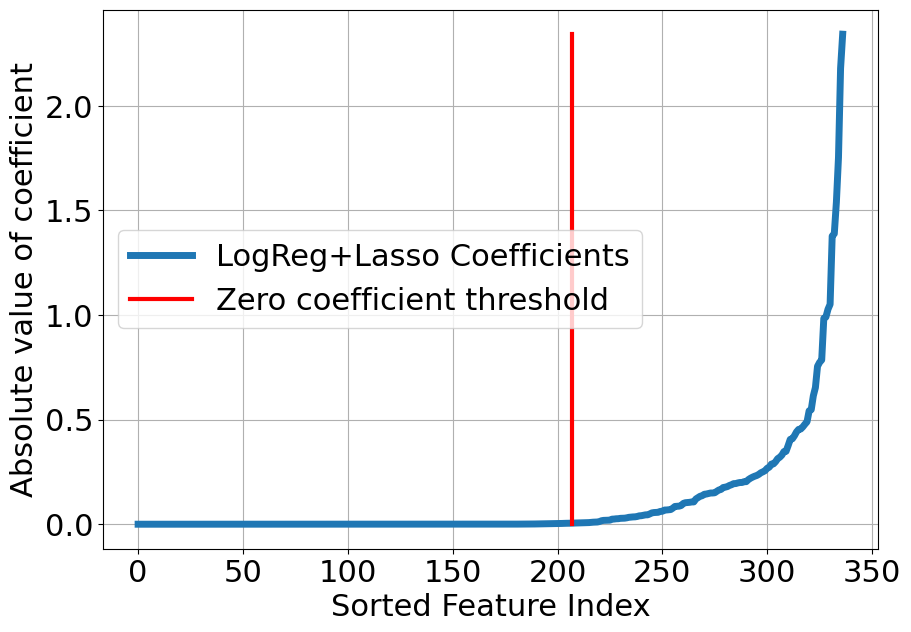

In [60]:
from matplotlib import pyplot as plt
from Funcs.Utility import  RANDOM_STATE
import numpy as np
import matplotlib
lasso_features, clf = exclude_with_lasso(features=agg_feature_after_corr, outcome_ds=labels_arm.reset_index()['stress_dyn'])
num_features = lasso_features.shape[1]
matplotlib.rc('font', size=22)

plt.figure(figsize=(10,7))
plt.grid()
plt.plot(np.sort(np.abs(clf.coef_[0])), linewidth=5, 
    label = 'LogReg+Lasso Coefficients'
)
plt.xlabel('Sorted Feature Index')
plt.ylabel("Absolute value of coefficient")

plt.plot(
    [len(clf.coef_[0]) - num_features,len(clf.coef_[0])- num_features]
    ,[0,np.max(np.abs(clf.coef_[0]))], color='red', linewidth=3
    , label='Zero coefficient threshold'
)
plt.legend()

In [61]:
feature_selection_meta = feature_selection_meta.append({
    'Removal step':'Lasso', 'Remaining number of features':130
},ignore_index=True)
feature_selection_meta

/tmp/ipykernel_173374/1858090365.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_selection_meta = feature_selection_meta.append({


,Removal step,Remaining number of features
0,Original AFs,928
1,Elimination of zero variance features,849
2,Elimination of mostly missing features,829
3,Elimination of pairwise correlations,337
4,Lasso,130


In [62]:
feature_selection_meta.to_csv('Results/feature_selection_meta.csv', index=False)

### Save selected features

In [63]:
agg_feature_names_selected = lasso_features.columns.to_list()
selected_features = list(
    set(map(lambda x: x[:x.find('|')], lasso_features))
)
print(len(selected_features))
pd.DataFrame({
    'features':selected_features
}).to_csv('Features/selected_features.csv',index=False)

113


## Feature Preparation before Rule Mining

### Get the selected features for rule mining

In [64]:
select_features = pd.read_csv(
                    'Features/selected_features.csv'
                )['features'].values.tolist()

### Extract Temporal Features from Sub Time Windows

In [ ]:
# Find the start of the day where first label is collected
start_of_week = label.index[0]
start_of_week = pd.Timestamp(start_of_week.date(), tz=DEFAULT_TZ)

# Define the end of the week as 7 days after the start of the week
end_of_week = start_of_week + pd.Timedelta(days=7)

# Adjust the time windows to cover the entire week
week_time_windows = []
for day in range(7):
    for i in range(8):
        start = start_of_week + pd.Timedelta(days=day) + pd.Timedelta(hours=i*3)
        end = start + pd.Timedelta(hours=3)
        if end <= end_of_week:
            week_time_windows.append((start, end))

# ...

# Features extracted from week epoch time windows
for count, (start, end) in enumerate(week_time_windows):
    # Get data for the current time window
    try:
        v = d_val_res.loc[start:end]
    except (KeyError, IndexError):
        continue
    day = count // 6
    epoch_name = epoch_names.get(count % 6)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        new_row = {f'{k}#Day{day}{epoch_name}': v for k, v in _extract_timeWindow_feature(is_numeric, cats, d_key, v).items()}
        row.update(new_row)

# ...
